# Job Recommendation for Stack Overflow users

## Goal 
Stack Overflow users can be ranked based on the number of questions they answer and the cumulative scores for all their answers. The goal is to recommend jobs for a specific user by building a profile strength for that user. The profile strength for a user can be determined using characteristics of users such as their skills, answers they gave and user "About Me" information.




## Data Description

There are two main datasets used in this project. 
#### 1. The Users dataset
The Users dataset is a combination of several datasets obtained from the Stack Overflow data dump. This dataset consists of Questions, Answers, associated scores and tags for each answer, user reputation and "About Me" information for each user. To understand how many answers were given by each user, I constructed a feature to count the number of answers given per user. All the questions and answers are based on computer science and programming.  

The Stack Overflow data dump can be found at:
* https://archive.org/details/stackexchange

#### 2. The Job descriptions dataset

The Job descriptions dataset was scrapped from online job boards. The goal was to retrieve all jobs related to Data science and Software Engineering. The following keywords were used in the search of all related job postings:
1. Data scientist
2. Data Engineer
3. Data Analyst
4. Data science
5. Machine learning
6. Business Analyst
7. Software engineer
8. Fullstack developer
9. Frontend developer
10. Backend developer

The locations used for the search:
1. San Francisco, CA
2. Mountain View, CA
3. Seattle, WA
4. New York, NY
5. Los Angeles, CA

The goal of scrapping the job boards was to obtain a detailed job description which comprised of all the skills required for that job. I used Scrapy to write a web crawler to recursively parse through all the job posting links for a given search parameter and location. 

The intial problem I encountered with scrapping the job board was the inconsistency in the structure of the job descriptions. Some job posting links were hosted by the job board whereas some links redirected to an external website. To overcome this problem, I parsed through each of the links to obtain the entire html code for that particular job description. This enabled me to grab all the required information related to job description even if it was redirected to an external website. 

## Data Munging and Cleaning

### 1. Users Dataset

The Users dataset is an amalgamation of the following datasets: 
 1. Questions dataset : This dataset consists of all the Questions related to computer science and programming.
 2. Answers dataset : This dataset consists of all Answers related to the respecitve questions.
 3. Users master dataset : This dataset consists of all users and their profile information.
 4. Tags dataset : The tags dataset consists of all tags associated with a particular question. Each question on Stack Overflow is tagged with certain keywords.
 
    ##### For example : " How can I concatenate two pandas dataframes?" 
    ##### The tags associated with this question would be "pandas","python" 
    

In [2]:
## Loading Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
%matplotlib inline

In [3]:
#Load Users data set :
users = pd.read_csv('users_profile.csv')

In [5]:
#Rename columns
users.rename(columns = {'Id_y_y': 'Answer_count','Body_y':'Answer_body','Score_y':'Answer_score','CreationDate_y':
                       'Answer_CreationDate','OwnerUserId_y':'Answer_OwnerId','Id_y_x':'Answer_id','Body_x':
                       'Question_body','Score_x':'Question_score','CreationDate_x':'Question_CreationDate',
                       'OwnerUserId_x':'Question_OwnerId','Id_x':'Question_id'},inplace=True)


In [20]:
#Drop unwanted column
users.drop(['Unnamed: 0','EmailHash'],axis=1,inplace=True)

In [21]:
#Snapshot of users data
users.head()

,Question_id,Question_OwnerId,Question_CreationDate,ParentId,Question_score,Question_body,Answer_id,Answer_OwnerId,Answer_CreationDate,ClosedDate,...,Location,Views,AboutMe,LastAccessDate,ProfileImageUrl,UpVotes,CreationDate,User_Id,AccountId,Answer_count
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers...",90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,...,"Indianapolis, IN",1278.0,<p>Front-End Engineer at Exact Target</p>\n\n<...,2016-08-26T14:17:54.537,NaN,957.0,2008-08-01T13:56:33.807,58.0,47.0,22
1,2973,92.0,2008-08-06T00:00:22Z,2970,3,"<p>With a six word character password, he may ...",2970,58.0,2008-08-05T23:55:25Z,2012-03-06T03:17:01Z,...,"Indianapolis, IN",1278.0,<p>Front-End Engineer at Exact Target</p>\n\n<...,2016-08-26T14:17:54.537,NaN,957.0,2008-08-01T13:56:33.807,58.0,47.0,22
2,2976,204.0,2008-08-06T00:16:07Z,2970,13,<p>Try and gather as much information as you c...,2970,58.0,2008-08-05T23:55:25Z,2012-03-06T03:17:01Z,...,"Indianapolis, IN",1278.0,<p>Front-End Engineer at Exact Target</p>\n\n<...,2016-08-26T14:17:54.537,NaN,957.0,2008-08-01T13:56:33.807,58.0,47.0,22
3,2978,419.0,2008-08-06T00:24:23Z,2970,2,<P>Is the site just plain static HTML? i.e. he...,2970,58.0,2008-08-05T23:55:25Z,2012-03-06T03:17:01Z,...,"Indianapolis, IN",1278.0,<p>Front-End Engineer at Exact Target</p>\n\n<...,2016-08-26T14:17:54.537,NaN,957.0,2008-08-01T13:56:33.807,58.0,47.0,22
4,3055,116.0,2008-08-06T03:31:22Z,2970,5,<p>You mention your Dad was using a website pu...,2970,58.0,2008-08-05T23:55:25Z,2012-03-06T03:17:01Z,...,"Indianapolis, IN",1278.0,<p>Front-End Engineer at Exact Target</p>\n\n<...,2016-08-26T14:17:54.537,NaN,957.0,2008-08-01T13:56:33.807,58.0,47.0,22


In [23]:
users.shape

(1982623, 30)

There are some users with 'None'as a description about themselves in the "About Me" column and some with NaN values. 
The idea is to select only the users with "About Me" information, so that this information can aid in building profile strength of user.

In [6]:
#Filter out users with "About Me" description and with Nan values
users_aboutme = users[users['AboutMe'] != 'None']
users_aboutme = users_aboutme[pd.notnull(users_aboutme['AboutMe'])]

In [ ]:
#Descriptive stats on users_aboutme 
users_aboutme.describe()

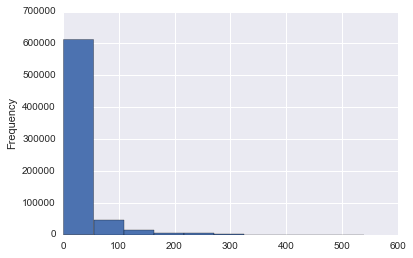

In [8]:
#Looking at distribution of Answer count per user
users_aboutme.Answer_count.plot(kind='hist')

In [14]:
#Pick threshold for Answer count -> 10 answers per user
users_profile = users_aboutme[users_aboutme['Answer_count'] > 10]

In [2]:
#Writing to csv file
#users_profile.to_csv('users_profile_final.csv')
users_profile = pd.read_csv('users_profile_final.csv')

##### Cleaning the Text columns with html tags -> AboutMe, Answers_body and Questions_body
Using BeautifulSoup to get only text from these columns

In [24]:
#Cleaning About me 
#users_profile['AboutMe'] = users_profile.loc[:,'AboutMe'].apply(lambda x: BeautifulSoup(x,"html.parser"))
users_profile['AboutMe'] = users_profile.loc[:,'AboutMe'].apply(lambda x: x.get_text())

/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/bs4/__init__.py:207: UserWarning: "http://www.youtube.com/watch?v=g1Qlzei-ArA" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/bs4/__init__.py:207: UserWarning: "http://twitter.com/ArtemR" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/User

In [27]:
users_profile['About_me'].unique()

array([ u'Front-End Engineer at Exact Target\nCo-Author of HTML, XHTML and CSS All-in-one Desk Reference for Dummies\nGraduated from IU with a Bachelors of Media Arts and Science and a Certificate in Applied Computer Science.\nTech Editor for Building Facebook Applications for Dummies and Building Websites All-in-one for Dummies 2nd Edition.\nCreator and maintainer of the Status-bar Calculator Firefox and Chrome extensions\nThree years professional experience in Java E-Commerce Development and four years professional experience with PHP\nTeach Server Side Programming with PHP and Mobile Applications Development at IUPUI\n',
       u'a long time ago i found an xss vuln here and took down the entire site\nuserid 26, respect\n',
       u"Full-Stack Developer at Stack Overflow, working to make our little corner of the Internet better for all of us.\nIf it consumes electricity, chances are good that I worked with it or at least know about it. Graduated as SysAdmin, turned Programmer. C# (AS

In [30]:
users_profile['About_me'] = users_profile.loc[:,'About_me'].apply(lambda x: x.lower())
users_profile['About_me']= users_profile.loc[:,'About_me'].apply(lambda x: x.strip("\n"))

/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [33]:
users_profile['About_me'].tail(20)

1968292                                     i'm a developer.
1968293                                     i'm a developer.
1968294                                     i'm a developer.
1968295                                     i'm a developer.
1968296                                     i'm a developer.
1968297                                     i'm a developer.
1968298                                     i'm a developer.
1968299                                     i'm a developer.
1968300                                     i'm a developer.
1976454    ui developer with 9 years of experience and kn...
1976455    ui developer with 9 years of experience and kn...
1976456    ui developer with 9 years of experience and kn...
1976457    ui developer with 9 years of experience and kn...
1976458    ui developer with 9 years of experience and kn...
1976459    ui developer with 9 years of experience and kn...
1976460    ui developer with 9 years of experience and kn...
1976461    ui developer 

In [35]:
#Cleaning Answers and Question body
users_profile['Answer_body'] = users_profile.loc[:,'Answer_body'].apply(lambda x: BeautifulSoup(x,"html.parser"))

users_profile['Answer_body'] = users_profile.loc[:,'Answer_body'].apply(lambda x: x.get_text())

users_profile['Answer_body'] = users_profile.loc[:,'Answer_body'].apply(lambda x: x.lower())
users_profile['Answer_body']=  users_profile.loc[:,'Answer_body'].apply(lambda x: x.strip("\n"))

In [ ]:
users_profile['Question_body'] = users_profile.loc[:,'Question_body'].apply(lambda x: BeautifulSoup(x,"html.parser"))
users_profile['Question_body'] = users_profile.loc[:,'Question_body'].apply(lambda x: x.get_text())

users_profile['Question_body'] = users_profile['Question_body'].apply(lambda x: x.lower())
users_profile['Question_body']= users_profile['Question_body'].apply(lambda x: x.strip("\n"))

### 2. Job Description Data

Job Descriptions dataset contains job descriptions in text, company name, title of the job, location

In [3]:
job_descriptions = pd.read_csv("jobs_final.csv")

In [4]:
job_descriptions.drop('Unnamed: 0',axis=1,inplace=True)

In [46]:
job_descriptions.head()

,node,J2EE,nosql,JavaScript,Redis,dl,RabbitMQ,kafka,linux,hbase,...,tensorflow,url,ml,seaborn,mapreduce,hive,summary,Csharp,spark,title
0,0,0,0,0,0,0,0,0,0,0,...,0.0,http://www.indeed.com/rc/clk?jk=aebef464939367...,0.0,0.0,0.0,0.0,"\n\n\n\n\n\n\n\n <a href=""http://www.grail...",0.0,0.0,DATA ANALYSIS SCIENTIST
1,0,0,0,0,0,0,0,0,0,0,...,0.0,http://www.indeed.com/rc/clk?jk=a823e56fe208ab...,0.0,0.0,0.0,0.0,\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r...,0.0,0.0,Data Analyst - Jr
2,0,0,0,1,0,0,0,0,0,0,...,0.0,http://www.indeed.com/rc/clk?jk=982a10d921a082...,0.0,0.0,0.0,0.0,"<!DOCTYPE html>\r\n<html lang=""en"">\r\n\t<head...",0.0,0.0,Data Scientist/Machine Learning Engineer
3,0,0,0,0,0,0,0,0,0,0,...,0.0,http://www.indeed.com/rc/clk?jk=dcdbb79f9a3dca...,0.0,0.0,0.0,1.0,<!DOCTYPE html><html><head><!--[if IE]>\n<meta...,0.0,0.0,Product Analyst
4,0,0,0,0,0,0,0,0,0,0,...,0.0,http://www.indeed.com/rc/clk?jk=f2d716747daeb7...,0.0,0.0,0.0,0.0,\n\n\n <!doctype html>\n <!--[if lt IE 7...,0.0,0.0,Marketing Analyst


In [48]:
#Cleaning Job description text -> summary
job_descriptions['summary'] = job_descriptions.loc[:,'summary'].apply(lambda x: BeautifulSoup(x,"html.parser"))
job_descriptions['job_descriptions'] = job_descriptions.loc[:,'summary'].apply(lambda x: x.get_text())

In [ ]:
job_descriptions.summary.apply(lambda x: x.lower())
job_descriptions.summary.apply(lambda x: x.strip("\n"))

## Exploratory Data Analysis

In [ ]:
#sns.distplot(users_profile.Reputation,kde=False,color='Red',bins=7)
fig = plt.figure(figsize=(10,7))
users_rep_dist = users_profile.Reputation.plot(kind='bar', color='green', alpha=0.7, 
                                           title= "Graph 1- Distribution of Reputation scores of Users\n")
users_rep_dist.set_xlabel("Reputation\n")
users_rep_dist.set_ylabel("Frequency\n")
#fig.savefig('../user_reputation_distribution.pdf') 
plt.show()

In [ ]:
#users_profile.groupby(['Answer_id'])['Answer_score'].sum().plot(kind='hist')

In [10]:
job_descriptions.describe()

/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,node,J2EE,nosql,JavaScript,Redis,dl,RabbitMQ,kafka,linux,hbase,...,statistics,XHTML,ruby,tensorflow,ml,seaborn,mapreduce,hive,Csharp,spark
count,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,...,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10562.000000,10561.000000,10561.000000
mean,0.193713,0.020829,0.047624,0.274569,0.026131,0.009089,0.009279,0.024711,0.007764,0.005397,...,0.144196,0.150066,0.005207,0.000189,0.131983,0.000095,0.000663,0.034653,0.073762,0.062494
std,0.395226,0.142820,0.212979,0.446318,0.159534,0.094907,0.095882,0.155251,0.087773,0.073267,...,0.351305,0.357153,0.071977,0.013760,0.338488,0.009730,0.025737,0.182907,0.261395,0.242062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
job_descriptions.ml.value_counts()

0.0    9168
1.0    1394
Name: ml, dtype: int64

In [19]:
job_descriptions.python.value_counts()

0.0    8229
1.0    2333
Name: python, dtype: int64

In [22]:
job_descriptions.XHTML.value_counts()

0.0    8977
1.0    1585
Name: XHTML, dtype: int64